In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from time import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import math

## **Loading the training set**


In [2]:
train = pd.read_csv('fmnist.csv')
print(train.shape)

train.describe()

(70000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.000000,70000.000000,70000.00000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,4.500000,0.000829,0.006743,0.037729,0.098371,0.242343,0.402571,0.808757,2.215843,5.649971,...,34.581886,23.268000,16.565943,17.86960,22.821271,17.894157,8.496757,2.723057,0.823229,0.069586
std,2.872302,0.088152,0.319931,1.472886,2.419523,4.360495,5.811048,8.269954,14.231137,23.754212,...,57.594114,48.882093,42.005114,43.99069,51.812432,45.146046,29.494913,17.261065,9.110774,2.099525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,57.000000,8.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,16.000000,45.000000,226.000000,185.000000,227.000000,230.000000,247.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.00000,255.000000,255.000000,255.000000,255.000000,255.000000,170.000000


### Selecting overlapping classes

In [3]:
#Choose from the MNIST set two of the most
#overlapping classes (e.g. from MNISTA 3 and 8; or 5.3; 4.9; 9.7).
#Create the filter
class_1 = 2
class_2 = 3
train_filter = np.where((train['label'] == class_1) | (train['label'] == class_2))

train_filter1 = np.where(train['label'] == class_1)
train_filter2 = np.where(train['label'] == class_2)

#Apply the filter
x_train = train.iloc[train_filter]

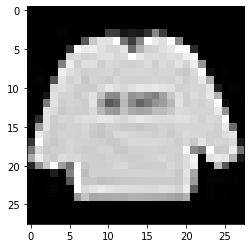

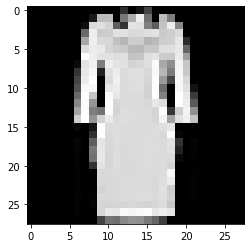

In [4]:
class1 = train.iloc[train_filter1]
class2 = train.iloc[train_filter2]

data = np.matrix(class1)
output = data[:, 0]
data = np.delete(data, 0, 1)
img = data[0].reshape(28,28)

plt.imshow(img, cmap="gray")
plt.show()

data = np.matrix(class2)
output = data[:, 0]
data = np.delete(data, 0, 1)
img = data[0].reshape(28,28)

plt.imshow(img, cmap="gray")
plt.show()

## **Dimensionality Reduction**
First of all we split the whole dataset in features and class, then we prepare the split of both sets to training and test set.

In [5]:
X_train = x_train.drop(['label'], axis='columns', inplace=False)
y_train = x_train['label']

from sklearn.model_selection import train_test_split
x_tr, x_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.30, random_state=4)

Using PCA, MNIST will be transform to 30-D space

In [6]:
#PCA
n_components = 30
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_train)

done in 1.289s


0.8526302920817581

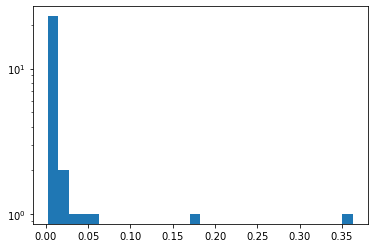

In [7]:
plt.hist(pca.explained_variance_ratio_, bins=n_components, log=True)
pca.explained_variance_ratio_.sum()

## Bagging

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

#This loop show us how the accuracy and F1 changes for the increasing number of classifiers
for n in range(2, 6):
    print("%i estimators:" % n)
    accuracy_sum = 0.0
    f1_sum = 0.0
    #We use Logistic Regression as the model for the BagginClassifier
    for sample_subset in np.arange(0.2, 1.0, 0.2):
        #We configure BaggingClassifier to get Bagging Classifier
        ensemble = BaggingClassifier(
            base_estimator=LogisticRegression(),
            n_estimators=n,
            max_samples=sample_subset,
            n_jobs=-1
        )
        ensemble.fit(X_train_pca, y_train)
        pred = ensemble.predict(X_train_pca)
        accuracy = metrics.accuracy_score(y_train, pred)
        f1 = metrics.f1_score(y_train, pred, average='macro')
        accuracy_sum += accuracy
        f1_sum += f1
        print("\t%3i%% of samples:" % int(sample_subset*100))
        print("\t\tAccuracy: %f" % accuracy)
        print("\t\tF1      : %f" % f1)
    print("\tMean Accuracy: %f" % (accuracy_sum/4))
    print("\tMean F1      : %f" % (f1_sum/4))

2 estimators:
	 20% of samples:
		Accuracy: 0.970929
		F1      : 0.970929
	 40% of samples:
		Accuracy: 0.972429
		F1      : 0.972429
	 60% of samples:
		Accuracy: 0.972500
		F1      : 0.972500
	 80% of samples:
		Accuracy: 0.971786
		F1      : 0.971786
	Mean Accuracy: 0.971911
	Mean F1      : 0.971911
3 estimators:
	 20% of samples:
		Accuracy: 0.971429
		F1      : 0.971428
	 40% of samples:
		Accuracy: 0.972214
		F1      : 0.972214
	 60% of samples:
		Accuracy: 0.972786
		F1      : 0.972786
	 80% of samples:
		Accuracy: 0.971857
		F1      : 0.971857
	Mean Accuracy: 0.972071
	Mean F1      : 0.972071
4 estimators:
	 20% of samples:
		Accuracy: 0.972857
		F1      : 0.972857
	 40% of samples:
		Accuracy: 0.972214
		F1      : 0.972214
	 60% of samples:
		Accuracy: 0.972071
		F1      : 0.972071
	 80% of samples:
		Accuracy: 0.972214
		F1      : 0.972214
	Mean Accuracy: 0.972339
	Mean F1      : 0.972339
5 estimators:
	 20% of samples:
		Accuracy: 0.971357
		F1      : 0.971357
	 40% of sampl

## Random Subspaces

In [10]:
for n in range(2, 6):
    print("%i estimators:" % n)
    accuracy_sum = 0.0
    f1_sum = 0.0
    for feature_subset in np.arange(0.2, 1.0, 0.2):
        #Configuration to create RandomForest
        ensemble = BaggingClassifier(
            base_estimator=LogisticRegression(),
            n_estimators=n,
            bootstrap=False,
            bootstrap_features=True,
            max_features=feature_subset,
            n_jobs=-1
        )
        ensemble.fit(X_train_pca, y_train)
        pred = ensemble.predict(X_train_pca)
        accuracy = metrics.accuracy_score(y_train, pred)
        f1 = metrics.f1_score(y_train, pred, average='macro')
        accuracy_sum += accuracy
        f1_sum += f1
        print("\t%3i%% of features:" % int(feature_subset*100))
        print("\t\tAccuracy: %f" % accuracy)
        print("\t\tF1      : %f" % f1)
    print("\tMean Accuracy: %f" % (accuracy_sum/4))
    print("\tMean F1      : %f" % (f1_sum/4))

2 estimators:
	 20% of features:
		Accuracy: 0.843929
		F1      : 0.843495
	 40% of features:
		Accuracy: 0.850143
		F1      : 0.849683
	 60% of features:
		Accuracy: 0.568571
		F1      : 0.568571
	 80% of features:
		Accuracy: 0.954571
		F1      : 0.954567
	Mean Accuracy: 0.804304
	Mean F1      : 0.804079
3 estimators:
	 20% of features:
		Accuracy: 0.542500
		F1      : 0.542433
	 40% of features:
		Accuracy: 0.537357
		F1      : 0.537264
	 60% of features:
		Accuracy: 0.723643
		F1      : 0.722991
	 80% of features:
		Accuracy: 0.962643
		F1      : 0.962641
	Mean Accuracy: 0.691536
	Mean F1      : 0.691332
4 estimators:
	 20% of features:
		Accuracy: 0.961214
		F1      : 0.961210
	 40% of features:
		Accuracy: 0.747429
		F1      : 0.746997
	 60% of features:
		Accuracy: 0.971571
		F1      : 0.971571
	 80% of features:
		Accuracy: 0.963000
		F1      : 0.962996
	Mean Accuracy: 0.910804
	Mean F1      : 0.910694
5 estimators:
	 20% of features:
		Accuracy: 0.949143
		F1      : 0.949138
	

## Random Patches (Bagging + Random Subspaces)

In [14]:
for sample_subset in np.arange(0.2, 1.2, 0.2):
    accuracy_sum = 0.0
    f1_sum = 0.0
    print("%3i%% of samples:" % int(sample_subset*100))
    for feature_subset in np.arange(0.2, 1.0, 0.2):
        ensemble = BaggingClassifier(
            base_estimator=LogisticRegression(),
            n_estimators=5,
            bootstrap_features=True,
            max_samples=sample_subset,
            max_features=feature_subset,
            n_jobs=-1
        )
        ensemble.fit(X_train_pca, y_train)
        pred = ensemble.predict(X_train_pca)
        accuracy = metrics.accuracy_score(y_train, pred)
        f1 = metrics.f1_score(y_train, pred, average='macro')
        print("\t%3i%% of features:" % int(feature_subset*100))
        print("\t\tAccuracy: %f" % accuracy)
        print("\t\tF1      : %f" % f1)
        accuracy_sum += accuracy
        f1_sum += f1
        
    print("\tMean Accuracy: %f" % (accuracy_sum/4))
    print("\tMean F1      : %f" % (f1_sum/4))

 20% of samples:
	 20% of features:
		Accuracy: 0.733500
		F1      : 0.733500
	 40% of features:
		Accuracy: 0.970000
		F1      : 0.970000
	 60% of features:
		Accuracy: 0.957643
		F1      : 0.957640
	 80% of features:
		Accuracy: 0.970357
		F1      : 0.970357
	Mean Accuracy: 0.907875
	Mean F1      : 0.907874
 40% of samples:
	 20% of features:
		Accuracy: 0.728857
		F1      : 0.728853
	 40% of features:
		Accuracy: 0.952214
		F1      : 0.952214
	 60% of features:
		Accuracy: 0.919357
		F1      : 0.919206
	 80% of features:
		Accuracy: 0.942643
		F1      : 0.942599
	Mean Accuracy: 0.885768
	Mean F1      : 0.885718
 60% of samples:
	 20% of features:
		Accuracy: 0.859571
		F1      : 0.859333
	 40% of features:
		Accuracy: 0.844357
		F1      : 0.843932
	 60% of features:
		Accuracy: 0.963000
		F1      : 0.963000
	 80% of features:
		Accuracy: 0.969714
		F1      : 0.969714
	Mean Accuracy: 0.909161
	Mean F1      : 0.908995
 80% of samples:
	 20% of features:
		Accuracy: 0.968429
		F1      

## RandomForest - subsets of samples

In [15]:
from sklearn.ensemble import RandomForestClassifier

for n in range(20, 220, 40):
    print("%i trees:" % n)
    accuracy_sum = 0.0
    f1_sum = 0.0
    for sample_subset in np.arange(0.2, 1.0, 0.2):
        ensemble = RandomForestClassifier(
            n_estimators=n,
            max_samples=sample_subset,
            random_state=0,
            n_jobs=-1
        )
        ensemble.fit(X_train_pca, y_train)
        pred = ensemble.predict(X_train_pca)
        accuracy = metrics.accuracy_score(y_train, pred)
        f1 = metrics.f1_score(y_train, pred, average='macro')
        print("\t%3i%% of samples:" % int(sample_subset*100))
        print("\t\tAccuracy: %f" % accuracy)
        print("\t\tF1      : %f" % f1)
        accuracy_sum += accuracy
        f1_sum += f1
        
    print("\tMean Accuracy: %f" % (accuracy_sum/4))
    print("\tMean F1      : %f" % (f1_sum/4))

20 trees:
	 20% of samples:
		Accuracy: 0.980571
		F1      : 0.980571
	 40% of samples:
		Accuracy: 0.989857
		F1      : 0.989857
	 60% of samples:
		Accuracy: 0.995143
		F1      : 0.995143
	 80% of samples:
		Accuracy: 0.998429
		F1      : 0.998429
	Mean Accuracy: 0.991000
	Mean F1      : 0.991000
60 trees:
	 20% of samples:
		Accuracy: 0.982929
		F1      : 0.982928
	 40% of samples:
		Accuracy: 0.991071
		F1      : 0.991071
	 60% of samples:
		Accuracy: 0.996643
		F1      : 0.996643
	 80% of samples:
		Accuracy: 0.999500
		F1      : 0.999500
	Mean Accuracy: 0.992536
	Mean F1      : 0.992536
100 trees:
	 20% of samples:
		Accuracy: 0.982500
		F1      : 0.982500
	 40% of samples:
		Accuracy: 0.991214
		F1      : 0.991214
	 60% of samples:
		Accuracy: 0.997500
		F1      : 0.997500
	 80% of samples:
		Accuracy: 0.999643
		F1      : 0.999643
	Mean Accuracy: 0.992714
	Mean F1      : 0.992714
140 trees:
	 20% of samples:
		Accuracy: 0.982857
		F1      : 0.982857
	 40% of samples:
		Accuracy

## RandomForest - subsets of features

In [17]:
for n in range(20, 220, 40):
    accuracy_sum = 0.0
    f1_sum = 0.0
    print("%i trees:" % n)
    for feature_subset in np.arange(0.2, 1.0, 0.2):
        ensemble = RandomForestClassifier(
            n_estimators=n,
            max_features=feature_subset,
            random_state=0,
            n_jobs=-1
        )
        ensemble.fit(X_train_pca, y_train)
        pred = ensemble.predict(X_train_pca)
        accuracy = metrics.accuracy_score(y_train, pred)
        f1 = metrics.f1_score(y_train, pred, average='macro')
        print("\t%3i%% of features:" % int(feature_subset*100))
        print("\t\tAccuracy: %f" % accuracy)
        print("\t\tF1      : %f" % f1)
        accuracy_sum += accuracy
        f1_sum += f1
    print("\tMean Accuracy: %f" % (accuracy_sum/4))
    print("\tMean F1      : %f" % (f1_sum/4))

20 trees:
	 20% of features:
		Accuracy: 0.999214
		F1      : 0.999214
	 40% of features:
		Accuracy: 0.999143
		F1      : 0.999143
	 60% of features:
		Accuracy: 0.998714
		F1      : 0.998714
	 80% of features:
		Accuracy: 0.998714
		F1      : 0.998714
	Mean Accuracy: 0.998946
	Mean F1      : 0.998946
60 trees:
	 20% of features:
		Accuracy: 1.000000
		F1      : 1.000000
	 40% of features:
		Accuracy: 1.000000
		F1      : 1.000000
	 60% of features:
		Accuracy: 0.999857
		F1      : 0.999857
	 80% of features:
		Accuracy: 0.999857
		F1      : 0.999857
	Mean Accuracy: 0.999929
	Mean F1      : 0.999929
100 trees:
	 20% of features:
		Accuracy: 1.000000
		F1      : 1.000000
	 40% of features:
		Accuracy: 1.000000
		F1      : 1.000000
	 60% of features:
		Accuracy: 1.000000
		F1      : 1.000000
	 80% of features:
		Accuracy: 1.000000
		F1      : 1.000000
	Mean Accuracy: 1.000000
	Mean F1      : 1.000000
140 trees:
	 20% of features:
		Accuracy: 1.000000
		F1      : 1.000000
	 40% of featur

## AdaBoost

In [18]:
from sklearn.ensemble import AdaBoostClassifier
accuracy_sum = 0.0
f1_sum = 0.0
for n in range(20, 220, 40):
    
    ensemble = AdaBoostClassifier(n_estimators=n, random_state=0)
    ensemble.fit(X_train_pca, y_train)
    pred = ensemble.predict(X_train_pca)
    accuracy = metrics.accuracy_score(y_train, pred)
    f1 = metrics.f1_score(y_train, pred, average='macro')
    print("%i trees:" % n)
    print("\tAccuracy: %f" % accuracy)
    print("\tF1      : %f" % f1)
    accuracy_sum += accuracy
    f1_sum += f1
print("\tMean Accuracy: %f" % (accuracy_sum/5))
print("\tMean F1      : %f" % (f1_sum/5))

20 trees:
	Accuracy: 0.967714
	F1      : 0.967714
60 trees:
	Accuracy: 0.972500
	F1      : 0.972500
100 trees:
	Accuracy: 0.973929
	F1      : 0.973929
140 trees:
	Accuracy: 0.976143
	F1      : 0.976143
180 trees:
	Accuracy: 0.977500
	F1      : 0.977500
	Mean Accuracy: 1.216946
	Mean F1      : 1.216946


In [19]:

print("\tMean Accuracy: %f" % (accuracy_sum/5))
print("\tMean F1      : %f" % (f1_sum/5))

	Mean Accuracy: 0.973557
	Mean F1      : 0.973557
